# Задание:
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
1. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
1. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
1. Обучите следующие модели:
одну из линейных моделей;
SVM;
дерево решений.
1. Оцените качество моделей с помощью трех подходящих для задачи метрик. Сравните качество полученных моделей.
1. Произведите для каждой модели подбор одного гиперпараметра с использованием GridSearchCV и кросс-валидации.
1. Повторите пункт 4 для найденных оптимальных значений гиперпараметров. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree

# Подключаем встроенные графики
%matplotlib inline

# Изменин формат сохранения графиков для улучшения отображения
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
#Подлючаем данные
data = pd.read_csv('SolarPrediction.csv', sep=",")

In [3]:
# Список колонок с типами данных
data.dtypes

UNIXTime                    int64
Data                       object
Time                       object
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
TimeSunRise                object
TimeSunSet                 object
dtype: object

In [4]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [5]:
#Преобразуем временные колонки в соответствующий временной формат:
data["Time"] = (pd
                    .to_datetime(data["UNIXTime"], unit="s", utc=True)
                    .dt.tz_convert("Pacific/Honolulu")).dt.time

data["TimeSunRise"] = (pd
                       .to_datetime(data["TimeSunRise"],
                                    infer_datetime_format=True)
                       .dt.time)

data["TimeSunSet"] = (pd
                      .to_datetime(data["TimeSunSet"],
                                   infer_datetime_format=True)
                      .dt.time)

data = data.rename({"WindDirection(Degrees)": "WindDirection"},
                   axis=1)

In [6]:
def time_to_second(t):
    return ((datetime.combine(datetime.min, t) - datetime.min)
            .total_seconds())

In [7]:
df = data.copy()

timeInSeconds = df["Time"].map(time_to_second)

sunrise = df["TimeSunRise"].map(time_to_second)
sunset = df["TimeSunSet"].map(time_to_second)
df["DayPart"] = (timeInSeconds - sunrise) / (sunset - sunrise)

df = df.drop(["UNIXTime", "Data", "Time",
              "TimeSunRise", "TimeSunSet"], axis=1)

df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
0,1.21,48,30.46,59,177.39,5.62,1.475602
1,1.21,48,30.46,58,176.78,3.37,1.468588
2,1.23,48,30.46,57,158.75,3.37,1.461713
3,1.21,48,30.46,60,137.71,3.37,1.454653
4,1.17,48,30.46,62,104.95,5.62,1.447778


In [8]:
df.dtypes

Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
DayPart          float64
dtype: object

In [9]:
df.shape

(32686, 7)

In [10]:
# Проверим наличие пустых значений
df.isnull().sum()

Radiation        0
Temperature      0
Pressure         0
Humidity         0
WindDirection    0
Speed            0
DayPart          0
dtype: int64

# Разделение данных.

In [11]:
X = df.drop("Radiation", axis=1)
y = df["Radiation"]
print(X.head(), "\n")
print(y.head())

   Temperature  Pressure  Humidity  WindDirection  Speed   DayPart
0           48     30.46        59         177.39   5.62  1.475602
1           48     30.46        58         176.78   3.37  1.468588
2           48     30.46        57         158.75   3.37  1.461713
3           48     30.46        60         137.71   3.37  1.454653
4           48     30.46        62         104.95   5.62  1.447778 

0    1.21
1    1.21
2    1.23
3    1.21
4    1.17
Name: Radiation, dtype: float64


In [12]:
print(X.shape)
print(y.shape)

(32686, 6)
(32686,)


In [13]:
#Разделим выборку на тренировочкую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24514, 6)
(8172, 6)
(24514,)
(8172,)


# Обучение моделей

In [14]:
#функция, которая считает метрики построенной модели:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Линейная модель — Lasso

In [15]:
#Попробуем метод Lasso с гиперпараметром alpha=1:
las_1 = Lasso(alpha=1.0)
las_1.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
test_model(las_1)

mean_absolute_error: 157.96025861976267
median_absolute_error: 124.33161677031507
r2_score: 0.5910368441088809


### SVM

In [17]:
#Попробуем метод NuSVR с гиперпараметром nu=0.5:
nusvr_05 = NuSVR(nu=0.5, gamma='scale')
nusvr_05.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [18]:
test_model(nusvr_05)

mean_absolute_error: 172.92453188479877
median_absolute_error: 101.9877834943342
r2_score: 0.41677135378183905


### Дерево решений

In [19]:
#Попробуем дерево решений с неограниченной глубиной дерева:
dt_none = DecisionTreeRegressor(max_depth=None)
dt_none.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [20]:
test_model(dt_none)

mean_absolute_error: 49.41742902594224
median_absolute_error: 0.7249999999999996
r2_score: 0.8371994122507448


In [21]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

#Оценим структуру получившегося дерева решений:
stat_tree(dt_none)

Всего узлов: 42969
Листовых узлов: 21485
Глубина дерева: 43
Минимальная глубина листьев дерева: 7
Средняя глубина листьев дерева: 20.743914358855015


# Подбор гиперпараметра K

### Линейная модель — Lasso

In [22]:
#Cписок настраиваемых параметров:
param_range = np.arange(0.001, 2.01, 0.1)
tuned_parameters = [{'alpha': param_range}]
tuned_parameters

[{'alpha': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
         6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
         1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
         1.801e+00, 1.901e+00, 2.001e+00])}]

In [23]:
# Подбор параметра
gs = GridSearchCV(Lasso(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

Lasso(alpha=0.101, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

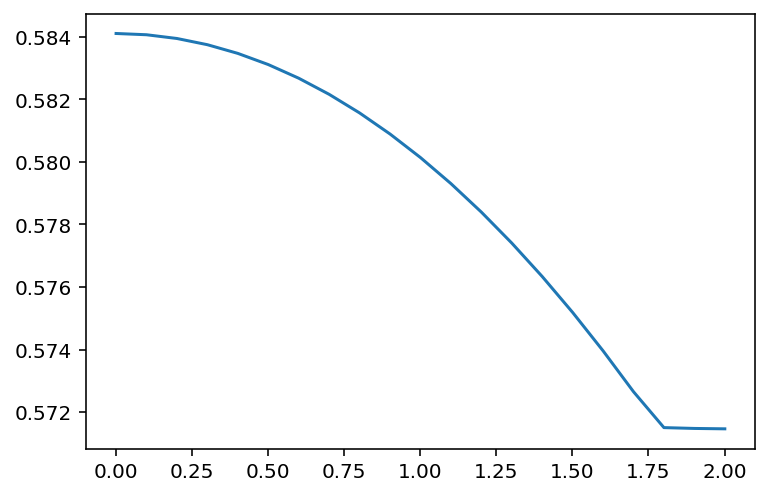

In [24]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

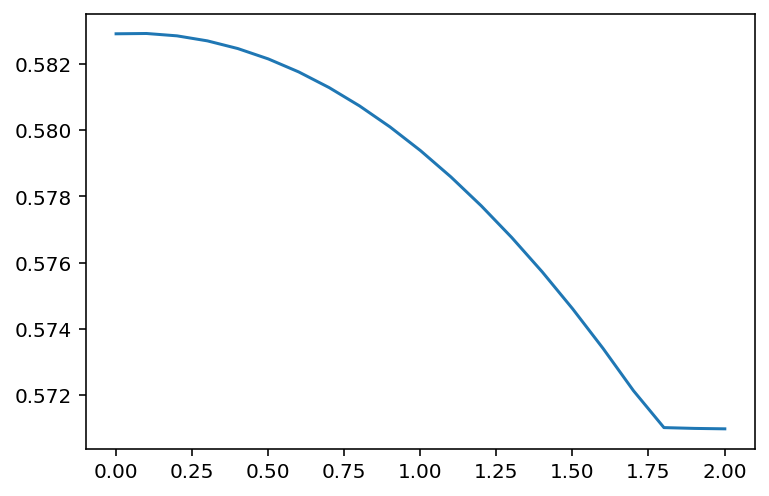

In [25]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [26]:
reg = LinearRegression()
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 156.41472692069752
median_absolute_error: 122.7350926314856
r2_score: 0.5961416061536914


### SVM

In [27]:
#Cписок настраиваемых параметров:
param_range = np.arange(0.1, 1.01, 0.1)
tuned_parameters = [{'nu': param_range}]
tuned_parameters

[{'nu': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}]

In [28]:
# Подбор параметра
gs = GridSearchCV(NuSVR(gamma='scale'), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

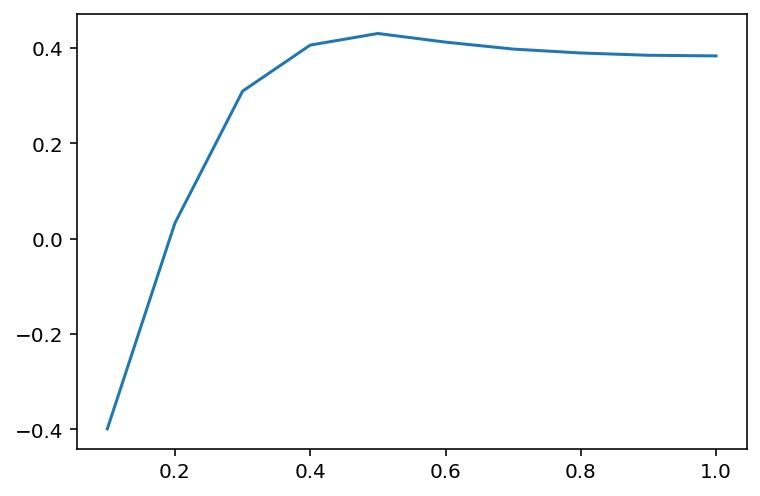

In [29]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

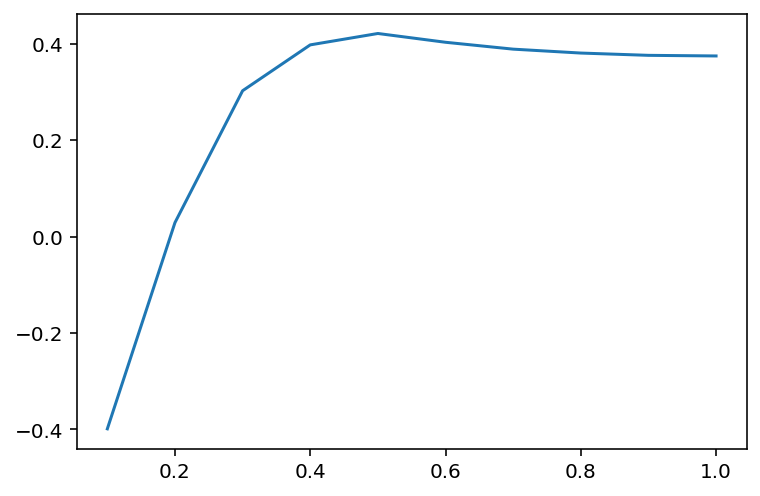

In [30]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

### Дерево решений

In [31]:
#Cписок настраиваемых параметров:
param_range = np.arange(1, 51, 2)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39, 41, 43, 45, 47, 49])}]

In [32]:
# Подбор параметра
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

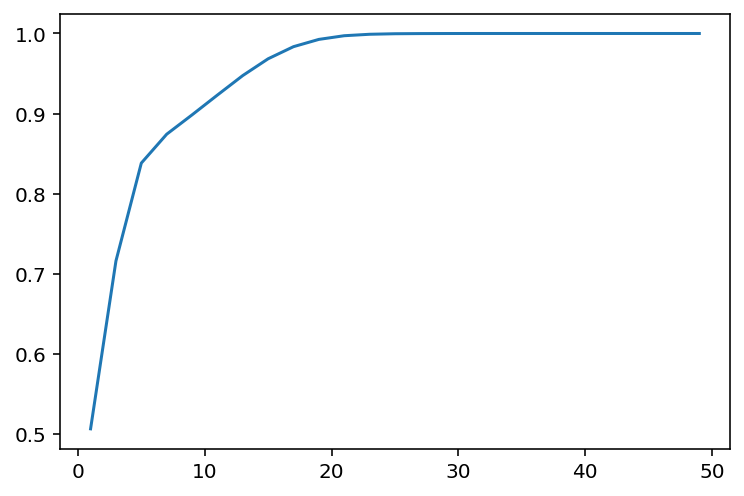

In [33]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

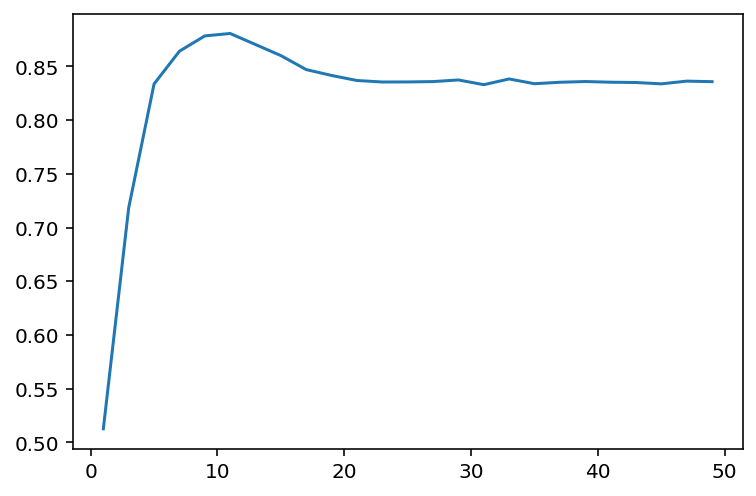

In [34]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [35]:
param_range = np.arange(7, 14, 1)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 7,  8,  9, 10, 11, 12, 13])}]

In [36]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

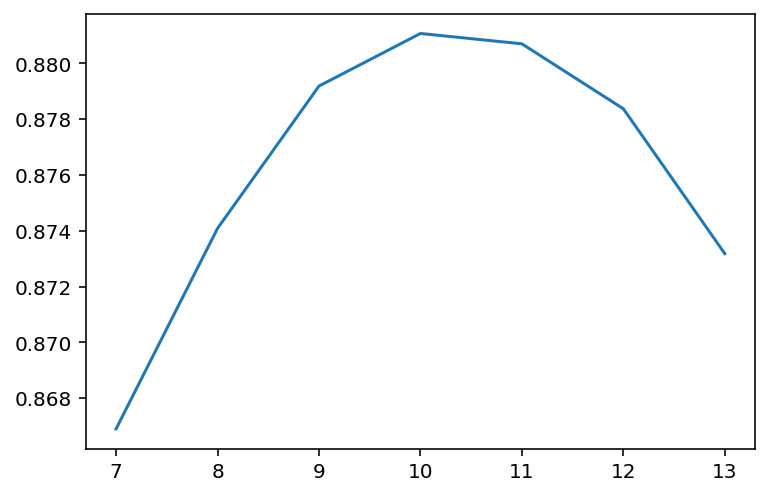

In [38]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [39]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 49.19982366267469
median_absolute_error: 0.9458444902162735
r2_score: 0.8729318611050234


In [40]:
stat_tree(reg)

Всего узлов: 1711
Листовых узлов: 856
Глубина дерева: 10
Минимальная глубина листьев дерева: 7
Средняя глубина листьев дерева: 9.850467289719626
